# Model Interpretation

**Goal:** Understand *how* the final trained XGBoost model makes predictions and which features drive those predictions. We will analyze feature importance and explore feature impacts and interactions using appropriate interpretation techniques.

## 1. Setup and Loading
*   Import necessary libraries for analysis, visualization, loading objects, and model interpretation (SHAP).
*   Load the saved final XGBoost model, the scaled training/testing data, the feature list, and the test target variable.

### Import Libraries
Import core libraries plus `joblib` for loading, `sklearn.inspection` for permutation importance, and `shap`.

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For loading model/scaler/features

# Scikit-learn for Permutation Importance
from sklearn.inspection import permutation_importance 
# Import metrics again if calculating importance based on score drop
from sklearn.metrics import mean_squared_error, r2_score 

# SHAP Library
try:
    import shap
    print(f"SHAP library imported successfully, version: {shap.__version__}")
    # Initialize SHAP JavaScript plots for notebooks
    shap.initjs() 
except ImportError:
    print("Error: SHAP library not found. Please install it (e.g., pip install shap or uv pip install shap)")
    shap = None

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x) 

# Configure plotting style
# plt.style.use('seaborn-v0_8-v0_8-whitegrid') # Re-apply style if needed
# sns.set_context("notebook", font_scale=1.1)

print("\nLibraries imported for interpretation.")

SHAP library imported successfully, version: 0.47.1


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Libraries imported for interpretation.


### Load Saved Model, Data, and Feature List
Load the trained XGBoost model, the scaled train/test feature sets, the test target variable, and the list of feature names used during training. Verify shapes and columns.

In [2]:
# Define paths
model_path = '../model/'
data_path = '../data/processed/' # Where scaled data was saved

# Initialize variables
final_model = None
scaler = None # Load scaler if needed for inverse transforming SHAP values potentially
X_train_scaled = None
X_test_scaled = None
y_test = None
final_features = None

try:
    # Load Model
    model_filename = 'xgb_price_predictor.joblib'
    final_model = joblib.load(model_path + model_filename)
    print(f"Loaded model from: {model_path + model_filename}")
    print(f"Model type: {type(final_model)}")

    # Load Scaler (might be needed later)
    scaler_filename = 'standard_scaler.joblib'
    scaler = joblib.load(model_path + scaler_filename)
    print(f"Loaded scaler from: {model_path + scaler_filename}")

    # Load Feature List
    features_filename = 'final_feature_list.joblib'
    final_features = joblib.load(model_path + features_filename)
    print(f"Loaded feature list from: {model_path + features_filename} ({len(final_features)} features)")

    # Load Data Splits (Parquet recommended)
    X_train_scaled = pd.read_parquet(data_path + 'X_train_scaled.parquet')
    X_test_scaled = pd.read_parquet(data_path + 'X_test_scaled.parquet')
    # y_train = pd.read_parquet(data_path + 'y_train.parquet')['log_price'] # Load train target if needed for SHAP background
    y_test = pd.read_parquet(data_path + 'y_test.parquet')['log_price'] 
    print("Loaded scaled training/testing data splits.")

    # --- Verification ---
    print("\nVerifying loaded data shapes:")
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape : {X_test_scaled.shape}")
    print(f"y_test shape : {y_test.shape}")

    # Verify test set columns match feature list
    if final_features is not None and list(X_test_scaled.columns) == final_features:
        print("Test data columns match the saved feature list.")
    elif final_features is not None:
        print("Warning: Test data columns MISMATCH saved feature list!")
        print(f"  Expected: {len(final_features)} features")
        print(f"  Found: {len(X_test_scaled.columns)} features")
        # Add further debugging if needed (e.g., compare sets of columns)

    # Verify model has expected number of features if possible
    if hasattr(final_model, 'n_features_in_'):
        if final_model.n_features_in_ == len(final_features):
            print(f"Model expects {final_model.n_features_in_} features, matching loaded feature list.")
        else:
            print(f"Warning: Model expects {final_model.n_features_in_} features, but loaded list has {len(final_features)}!")

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure previous steps saved artifacts correctly.")
except Exception as e:
    print(f"An error occurred during loading: {e}")

Loaded model from: ../model/xgb_price_predictor.joblib
Model type: <class 'xgboost.sklearn.XGBRegressor'>
Loaded scaler from: ../model/standard_scaler.joblib
Loaded feature list from: ../model/final_feature_list.joblib (54 features)
Loaded scaled training/testing data splits.

Verifying loaded data shapes:
X_train_scaled shape: (6979, 54)
X_test_scaled shape : (1745, 54)
y_test shape : (1745,)
Test data columns match the saved feature list.
Model expects 54 features, matching loaded feature list.


## 2. Feature Importance Analysis

In this phase, we investigate which features the trained XGBoost model considers most important for making predictions. We will use two different methods:
*   **Built-in Importance:** Utilizing XGBoost's internal calculation (based on feature usage like gain or weight).
*   **Permutation Importance:** Assessing importance by measuring the drop in model performance when a feature's values are randomly shuffled on the test set.
Comparing these methods provides a more robust understanding of feature influence.

### Extract Built-in Importance (XGBoost)
Retrieve and visualize the feature importance scores calculated internally by the trained XGBoost model. XGBoost provides different importance types ('weight', 'gain', 'cover'); 'gain' (average gain across splits where feature was used) is often a good default.

Extracting built-in feature importances from XGBoost model...

Top 30 Features by Built-in Importance (Gain/Default):


,Feature,Importance_Gain
34,bedrooms_log,0.24574
36,accommodates_log,0.06401
28,bathrooms_log,0.05988
3,property_type,0.05246
44,room_type_Entire_home/apt,0.04602
52,neighbourhood_group_Old_Town_Center,0.04257
19,amenity_tv,0.03386
39,host_response_time_Unknown,0.03385
47,room_type_Shared_room,0.03139
35,reviews_per_month_log,0.02241


/tmp/ipykernel_50086/2458220106.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance_Gain', y='Feature',


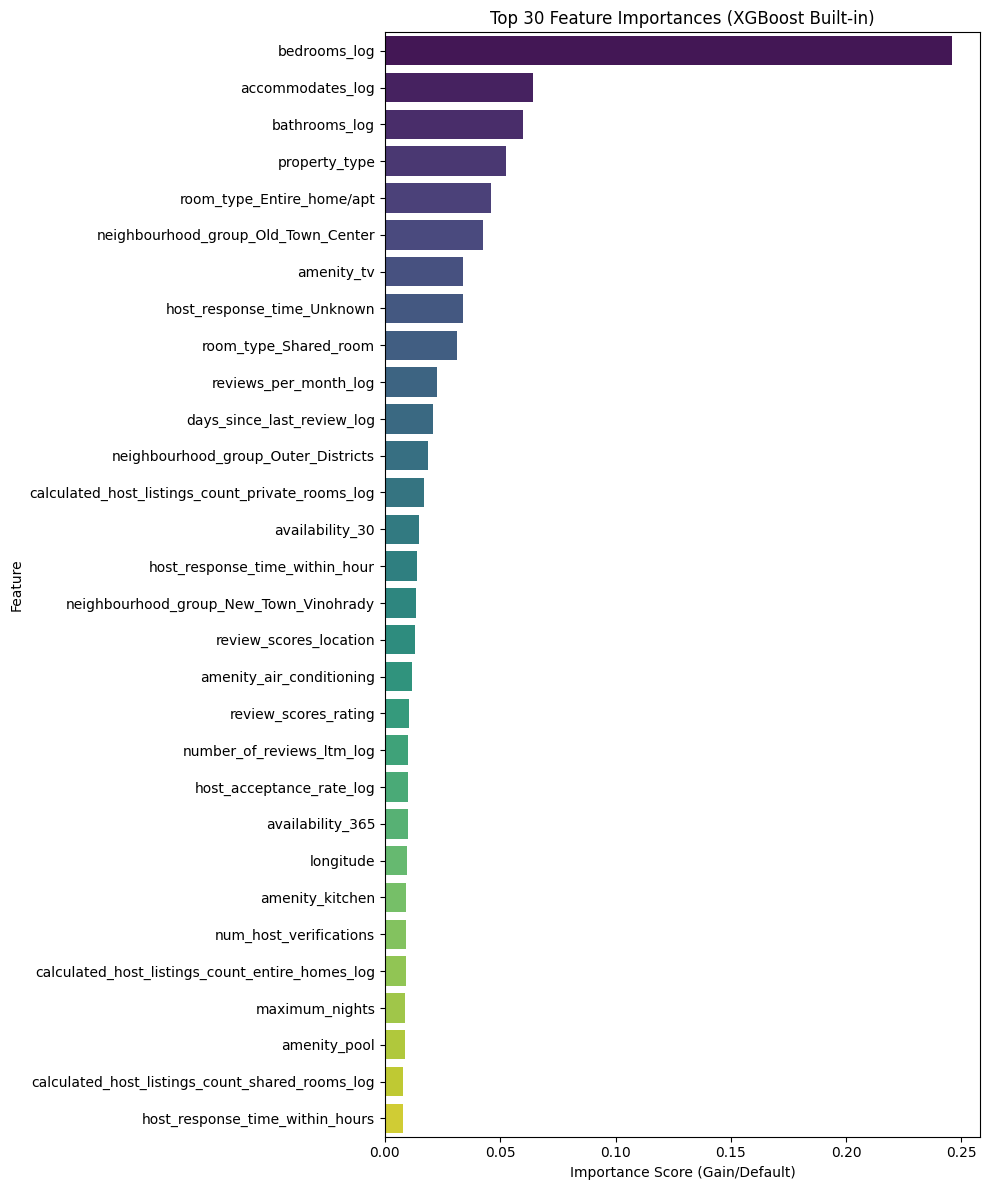

In [3]:
# I2.1 Extract Built-in Importance (XGBoost)
if ('final_model' in locals() and final_model is not None and 
    hasattr(final_model, 'feature_importances_') and 
    'X_train_scaled' in locals() and X_train_scaled is not None): # Need column names

    print("Extracting built-in feature importances from XGBoost model...")
    
    try:
        # XGBoost models usually have .feature_importances_ which defaults to 'gain' 
        # if booster is gbtree, but let's be explicit if possible or just use the default.
        # Alternatively, access specific types via: final_model.get_booster().get_score(importance_type='gain') 
        # but .feature_importances_ is standard scikit-learn API.
        
        importances = final_model.feature_importances_
        feature_names = X_train_scaled.columns # Get feature names from training data columns
        
        if len(importances) == len(feature_names):
            # Create DataFrame
            importance_df_builtin = pd.DataFrame({
                'Feature': feature_names,
                'Importance_Gain': importances # Assuming default is gain-based
            }).sort_values(by='Importance_Gain', ascending=False)

            print(f"\nTop 30 Features by Built-in Importance (Gain/Default):")
            display(importance_df_builtin.head(30))

            # Plotting
            plt.figure(figsize=(10, 12)) 
            sns.barplot(x='Importance_Gain', y='Feature', 
                        data=importance_df_builtin.head(30), 
                        palette='viridis')
            plt.title('Top 30 Feature Importances (XGBoost Built-in)')
            plt.xlabel('Importance Score (Gain/Default)')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
        else:
             print(f"Error: Mismatch between number of importances ({len(importances)}) and features ({len(feature_names)}).")

    except Exception as e:
        print(f"An error occurred extracting built-in importances: {e}")

else:
    print("Error: Final model or training data not available, or model doesn't have feature_importances_ attribute.")

*Observation:* XGBoost's built-in feature importance (likely based on gain) ranks **`bedrooms_log`** as overwhelmingly the most important feature, followed by **`accommodates_log`**, **`bathrooms_log`**, target-encoded **`property_type`**, and specific OHE categories like **`room_type_Entire_home/apt`** and **`neighbourhood_group_Old_Town_Center`**. Other notable features include `amenity_tv`, the indicator for unknown host response time (`host_response_time_Unknown`), and `room_type_Shared_room`. Location coordinates (`latitude`/`longitude`) appear further down the list based on this metric.

### Calculate Permutation Importance
Compute feature importance by measuring the decrease in test set performance (using R² score) when each feature's values are randomly shuffled. This assesses the feature's contribution to the model's predictive power on unseen data.

Calculating Permutation Importance on the test set...
(This may take a few minutes depending on n_repeats and data size)...


/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [16:29:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/viktor/Projects/datax_airbnb/venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [16:29:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device o

Permutation Importance calculation complete. Time taken: 7.08 seconds.

Top 30 Features by Permutation Importance (Mean Drop in R2):


,Feature,Importance_Mean,Importance_Std
34,bedrooms_log,0.15263,0.00687
36,accommodates_log,0.14850,0.00669
32,days_since_last_review_log,0.05063,0.00352
3,property_type,0.04747,0.00221
35,reviews_per_month_log,0.04204,0.00384
6,availability_30,0.03851,0.00295
8,review_scores_rating,0.03764,0.00176
28,bathrooms_log,0.03574,0.00246
7,availability_365,0.03056,0.00430
37,calculated_host_listings_count_entire_homes_log,0.03046,0.00315


/tmp/ipykernel_50086/1763617326.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(perm_importance_result.importances[sorted_idx].T,


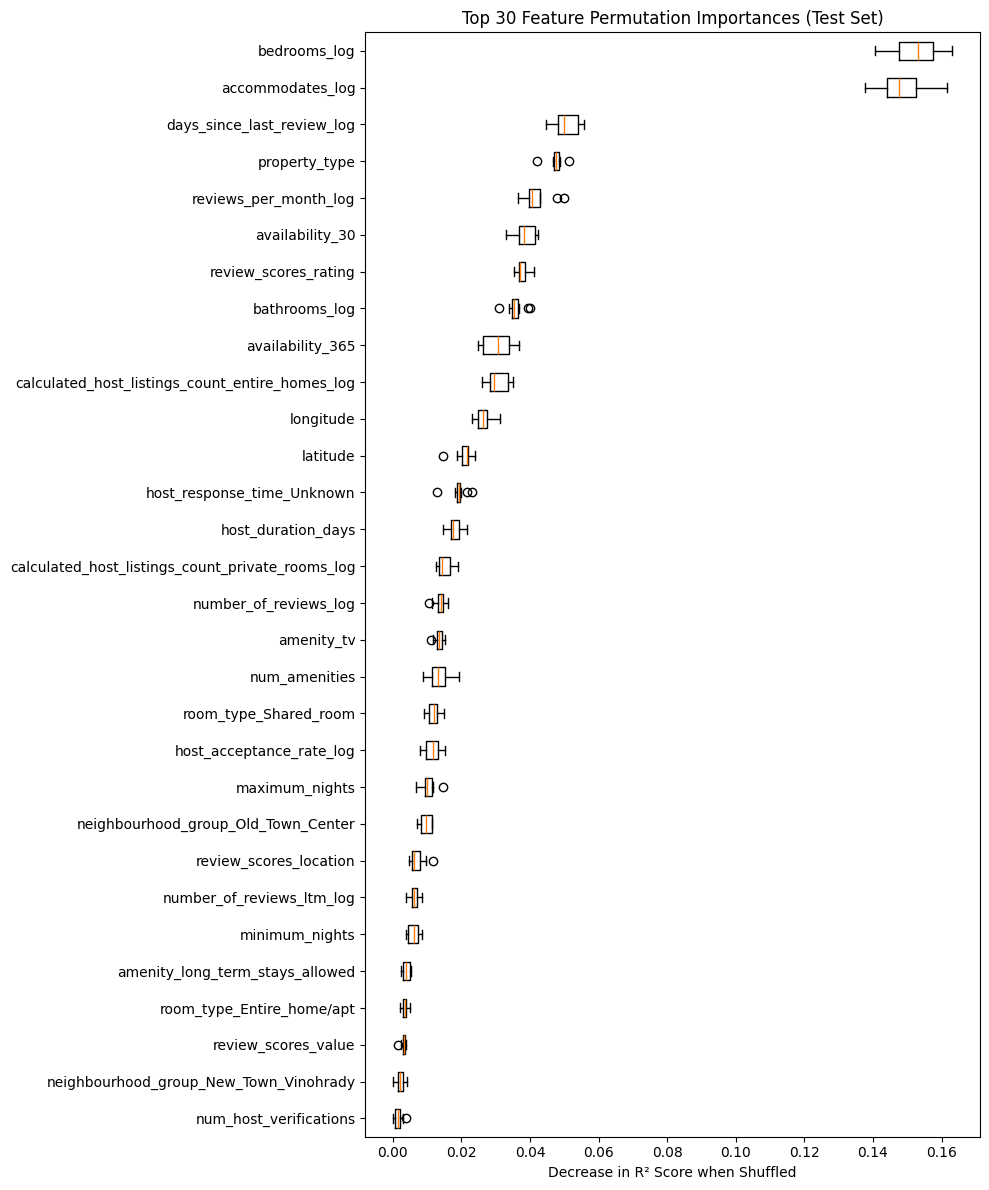

In [6]:
import time

# I2.2 Calculate Permutation Importance
if ('final_model' in locals() and final_model is not None and 
    'X_test_scaled' in locals() and 'y_test' in locals() and
    X_test_scaled is not None and y_test is not None):
    
    print("Calculating Permutation Importance on the test set...")
    print("(This may take a few minutes depending on n_repeats and data size)...")
    start_time = time.time()

    # Use R2 score as metric - higher is better, drop when shuffling indicates importance
    # Alternatively use 'neg_root_mean_squared_error' - lower is better, increase when shuffling indicates importance
    scoring_metric = 'r2' 
    
    try:
        perm_importance_result = permutation_importance(
            final_model,
            X_test_scaled,
            y_test,
            n_repeats=10, # Number of times to shuffle each feature
            random_state=42,
            scoring=scoring_metric,
            n_jobs=-1 # Use available cores
        )
        
        end_time = time.time()
        print(f"Permutation Importance calculation complete. Time taken: {(end_time - start_time):.2f} seconds.")

        # Store results in a DataFrame
        perm_importance_df = pd.DataFrame({
            'Feature': X_test_scaled.columns,
            'Importance_Mean': perm_importance_result.importances_mean,
            'Importance_Std': perm_importance_result.importances_std
        }).sort_values(by='Importance_Mean', ascending=False)

        print(f"\nTop 30 Features by Permutation Importance (Mean Drop in {scoring_metric.upper()}):")
        display(perm_importance_df.head(30))
        
        # --- Plotting Permutation Importance ---
        plt.figure(figsize=(10, 12))
        # Select top N for plotting
        plot_n = 30
        sorted_idx = perm_importance_result.importances_mean.argsort()[-plot_n:]
        
        plt.boxplot(perm_importance_result.importances[sorted_idx].T,
                    vert=False, labels=X_test_scaled.columns[sorted_idx])
        plt.title(f'Top {plot_n} Feature Permutation Importances (Test Set)')
        plt.xlabel(f'Decrease in R² Score when Shuffled') # Adjust label based on scoring_metric
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during Permutation Importance calculation: {e}")

else:
    print("Error: Final model or test data not available for Permutation Importance.")

*Observation:* Permutation importance calculated on the test set (measuring the drop in R² score) confirms **`bedrooms_log`** and **`accommodates_log`** as the top two most critical features for predictive performance. Following them are review recency (`days_since_last_review_log`), target-encoded **`property_type`**, review velocity (`reviews_per_month_log`), short-term availability (`availability_30`), and overall **`review_scores_rating`**. Location (`longitude`, `latitude`) also appears important. Unlike the built-in method, specific `room_type` or `neighbourhood_group` categories (except `Old_Town_Center` and `Shared_room`) rank lower here, suggesting their individual impact on R² might be smaller when considered in isolation, although `bathrooms_log` remains significant.

*Observation:* Comparing the two importance methods:
*   **Conclusion:** The core drivers appear to be listing size, property type, location (coordinates), availability, and review characteristics (rating, recency, velocity). While built-in importance highlights frequently used split features, permutation importance likely gives a better estimate of true predictive value on unseen data. We will focus on these core drivers for SHAP analysis.

## 3. SHAP (SHapley Additive exPlanations) Analysis

SHAP values provide a powerful way to understand model predictions by quantifying the contribution of each feature to individual predictions in a fair and consistent manner (based on cooperative game theory). We will:
*   Initialize a SHAP explainer suitable for our XGBoost model.
*   Calculate SHAP values for the test set.
*   Analyze global feature importance and impact using SHAP summary plots (beeswarm and bar).
*   Investigate the impact of top features and their main interactions using SHAP dependence plots.
*   (Optional) Examine individual predictions.

### Initialize SHAP Explainer
Create a `shap.TreeExplainer` instance using the final trained XGBoost model.

In [7]:
# I3.1 Initialize SHAP Explainer
# Ensure SHAP was imported successfully in I1.1
if 'shap' in locals() and shap is not None and 'final_model' in locals() and final_model is not None:
    print("Initializing SHAP TreeExplainer...")
    try:
        # TreeExplainer is optimized for tree-based models like XGBoost
        explainer = shap.TreeExplainer(final_model)
        print("SHAP TreeExplainer initialized successfully.")
        
        # Check explainer type
        # print(f"Explainer type: {type(explainer)}")
        
    except Exception as e:
        print(f"Error initializing SHAP explainer: {e}")
        explainer = None
else:
    print("Error: SHAP library or final_model not available.")
    explainer = None

Initializing SHAP TreeExplainer...
SHAP TreeExplainer initialized successfully.


### Calculate SHAP Values
Compute SHAP values for all instances in the scaled test set (`X_test_scaled`). This shows the contribution of each feature to each individual prediction's deviation from the base value.

In [8]:
# I3.2 Calculate SHAP Values
if 'explainer' in locals() and explainer is not None and 'X_test_scaled' in locals() and X_test_scaled is not None:
    print("Calculating SHAP values for the test set...")
    print("(This may take a moment depending on model complexity and data size)...")
    start_time = time.time()
    
    try:
        # Calculate SHAP values
        # For TreeExplainer, .shap_values() typically returns raw values directly
        shap_values = explainer.shap_values(X_test_scaled)
        
        # Alternative if using explainer():
        # explanation = explainer(X_test_scaled)
        # shap_values = explanation.values # Extract values if using Explanation object
        # base_value = explanation.base_values # Get base value if needed
        
        end_time = time.time()
        print(f"SHAP values calculation complete. Time taken: {(end_time - start_time):.2f} seconds.")
        
        # Verify shape (should be same as X_test_scaled: samples x features)
        print(f"Shape of SHAP values array: {shap_values.shape}")
        print(f"Shape of X_test_scaled : {X_test_scaled.shape}")
        if shap_values.shape == X_test_scaled.shape:
            print("SHAP values shape matches X_test_scaled shape.")
        else:
            print("Warning: SHAP values shape does NOT match X_test_scaled shape!")
            
    except Exception as e:
        print(f"An error occurred during SHAP value calculation: {e}")
        shap_values = None
        
else:
    print("Error: SHAP explainer or test data not available.")

Calculating SHAP values for the test set...
(This may take a moment depending on model complexity and data size)...
SHAP values calculation complete. Time taken: 0.25 seconds.
Shape of SHAP values array: (1745, 54)
Shape of X_test_scaled : (1745, 54)
SHAP values shape matches X_test_scaled shape.


### Global Interpretation with SHAP Summary Plots
Visualize the overall feature importance and impact using SHAP summary plots.

Generating SHAP Beeswarm Summary Plot...


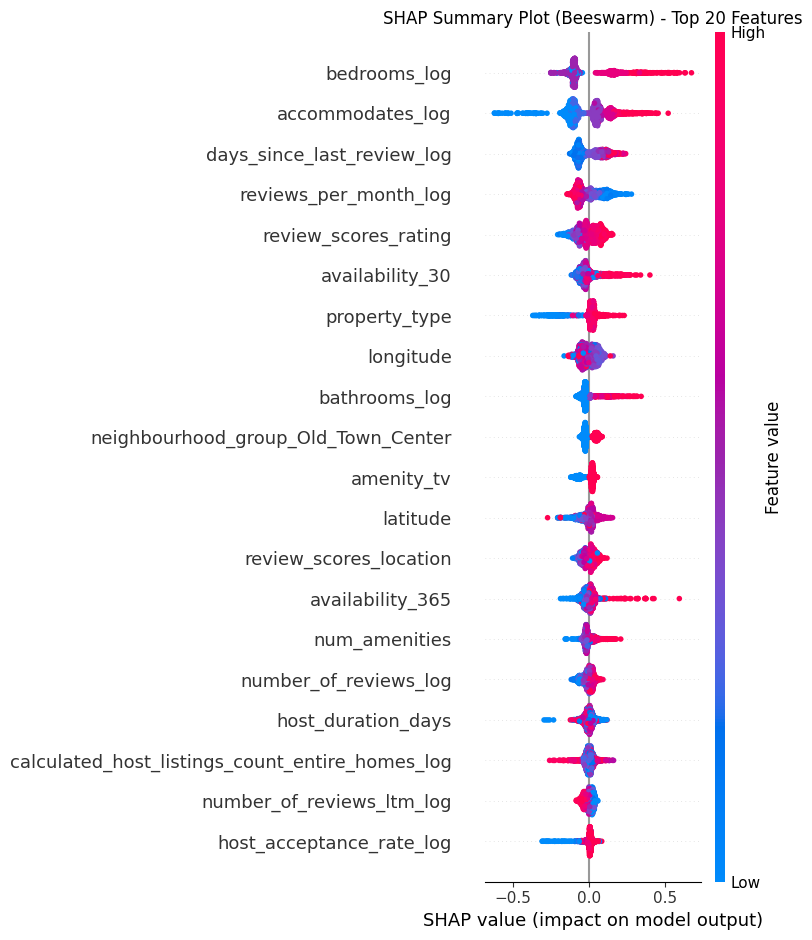

In [9]:
# I3.3a SHAP Beeswarm Summary Plot
if 'shap_values' in locals() and shap_values is not None and 'X_test_scaled' in locals() and X_test_scaled is not None:
    print("Generating SHAP Beeswarm Summary Plot...")
    try:
        shap.summary_plot(
            shap_values, 
            X_test_scaled, 
            plot_type='dot', # Beeswarm plot
            max_display=20, # Show top N features
            show=False # Prevent immediate display, allow plt adjustments
        )
        plt.title('SHAP Summary Plot (Beeswarm) - Top 20 Features')
        plt.tight_layout() # Adjust layout
        plt.show() # Display the plot generated by SHAP
    except Exception as e:
        print(f"An error occurred generating beeswarm plot: {e}")
else:
    print("Error: SHAP values or test data not available for beeswarm plot.")

*Observation:* The SHAP beeswarm plot visually ranks features by the spread and magnitude of their SHAP values across the test set. Key insights include:
*   **Top Features:** `bedrooms_log`, `accommodates_log`, `days_since_last_review_log`, `reviews_per_month_log`, and `review_scores_rating` clearly show the widest distributions, indicating they have the largest impact on predictions for many listings.
*   **Directionality:**
    *   Higher values of `bedrooms_log` and `accommodates_log` (pink/red points) consistently have positive SHAP values, pushing the predicted `log_price` higher. Lower values (blue points) have negative SHAP values.
    *   Lower values of `days_since_last_review_log` (more recent reviews - pink/red points) generally have positive SHAP values (increasing predicted price), while higher values (older/no reviews - blue points, including the cluster near ~9.2) have negative SHAP values (decreasing predicted price).
    *   Higher `reviews_per_month_log` (pink/red) tends to have a positive SHAP value.
    *   Higher `review_scores_rating` (pink/red) generally has a positive SHAP value, increasing predicted price.
    *   `availability_30`: Lower availability (pink/red points, meaning value closer to 0 days available) has a positive impact (higher predicted price), while higher availability (blue points) has a negative impact.
    *   `property_type` (Target Encoded): Higher encoded values (representing types with higher average prices - pink/red) have positive SHAP values.
    *   `longitude`: Shows a complex pattern, with both high and low values potentially having positive or negative impacts, suggesting a non-linear geographical effect.
    *   `neighbourhood_group_Old_Town_Center`: Being in this group (value 1 - pink/red) generally has a positive SHAP value, increasing predicted price.
*   **Importance Ranking:** The vertical ordering generally aligns with permutation importance, confirming the significance of size, review recency/velocity/rating, availability, property type, and location.


Generating SHAP Bar Summary Plot...


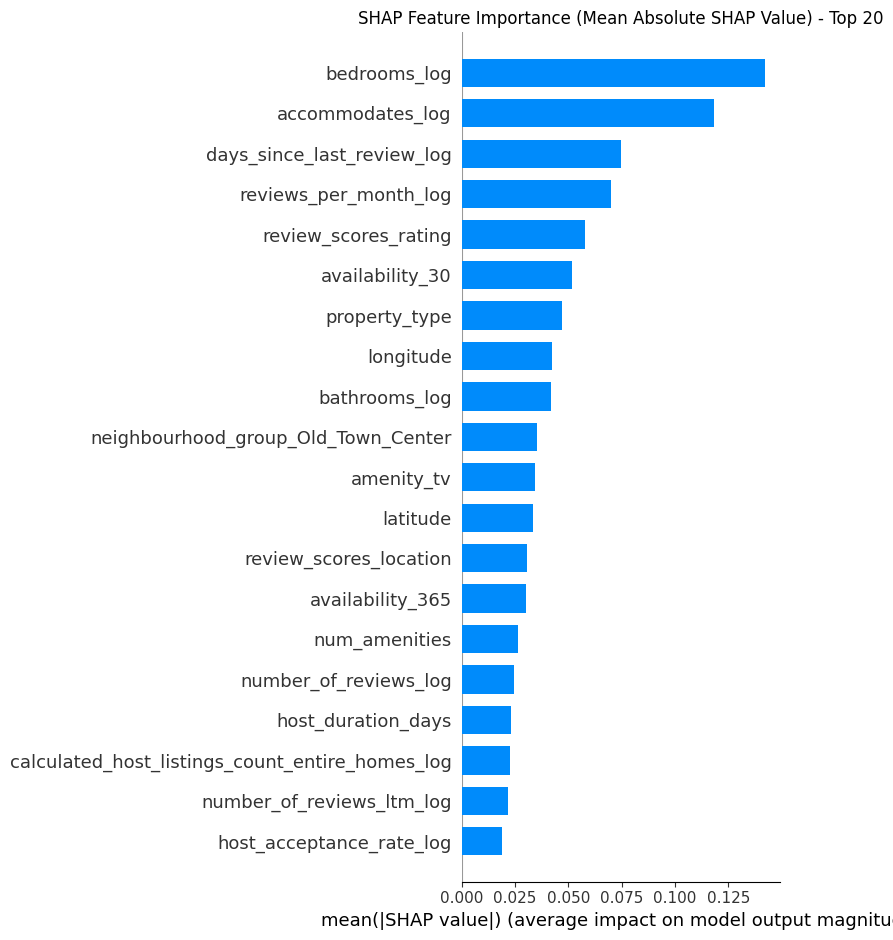

In [10]:
# I3.3b SHAP Bar Summary Plot
if 'shap_values' in locals() and shap_values is not None and 'X_test_scaled' in locals() and X_test_scaled is not None:
    print("\nGenerating SHAP Bar Summary Plot...")
    try:
        shap.summary_plot(
            shap_values, 
            X_test_scaled, 
            plot_type='bar', # Bar plot
            max_display=20, # Show top N features
            show=False
        )
        plt.title('SHAP Feature Importance (Mean Absolute SHAP Value) - Top 20')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred generating bar plot: {e}")
else:
    print("Error: SHAP values or test data not available for bar plot.")

*Observation:* The SHAP bar plot, ranking features by their mean absolute SHAP value (|SHAP value|), provides a clear global importance hierarchy. It confirms that `bedrooms_log` and `accommodates_log` have the largest average impact on model output magnitude. These are followed by `days_since_last_review_log`, `reviews_per_month_log`, `review_scores_rating`, `availability_30`, `property_type` (target encoded), and `longitude`. This ranking is highly consistent with the permutation importance results, reinforcing confidence in identifying the key drivers of the model's predictions.

### Analyze Feature Impacts and Interactions with SHAP Dependence Plots
Investigate the relationship between the value of top features and their impact on the prediction (SHAP value), including interaction effects with other features.


Generating SHAP Dependence Plots for Top Features: ['bedrooms_log', 'accommodates_log', 'bathrooms_log', 'property_type', 'room_type_Entire_home/apt', 'neighbourhood_group_Old_Town_Center', 'amenity_tv', 'host_response_time_Unknown']

Plotting dependence for: bedrooms_log


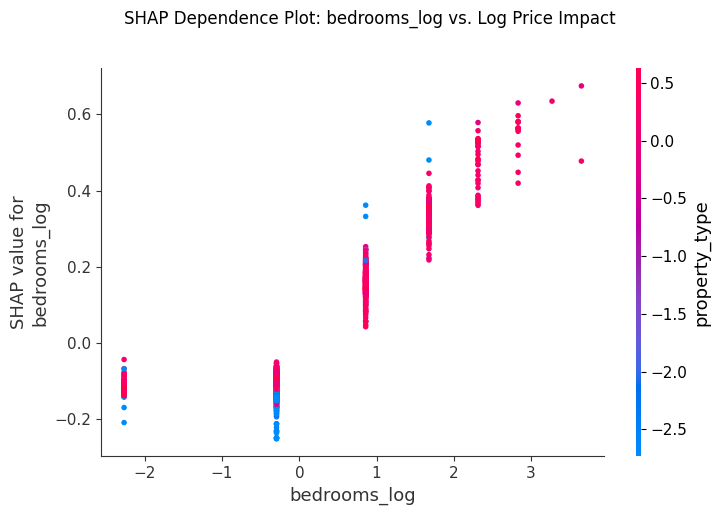


Plotting dependence for: accommodates_log


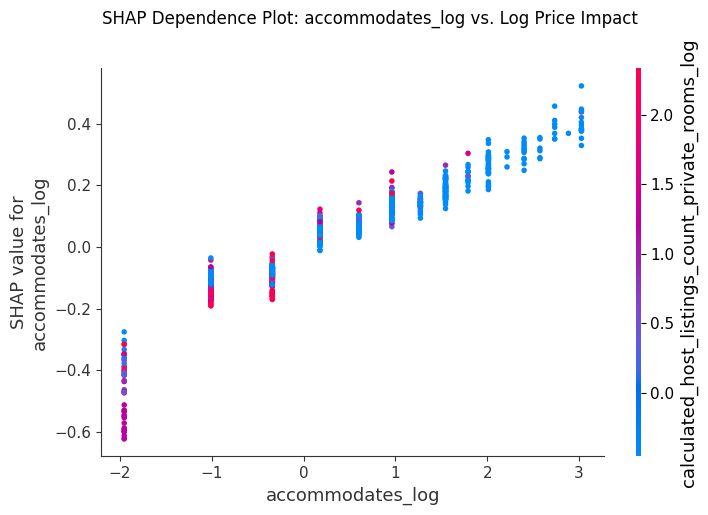


Plotting dependence for: bathrooms_log


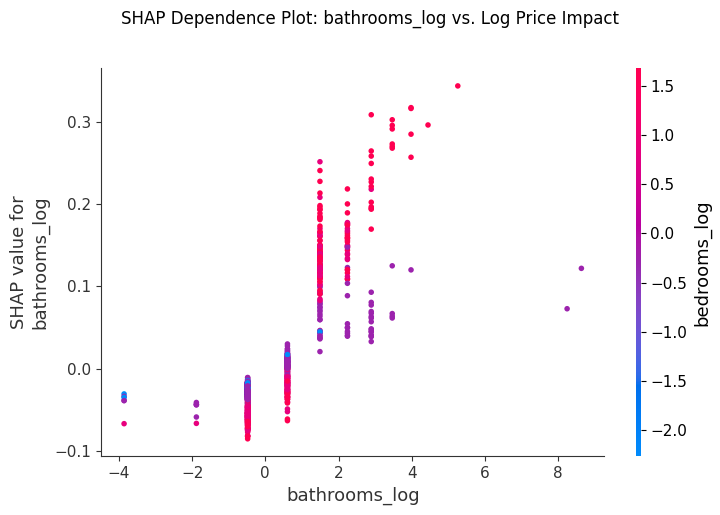


Plotting dependence for: property_type


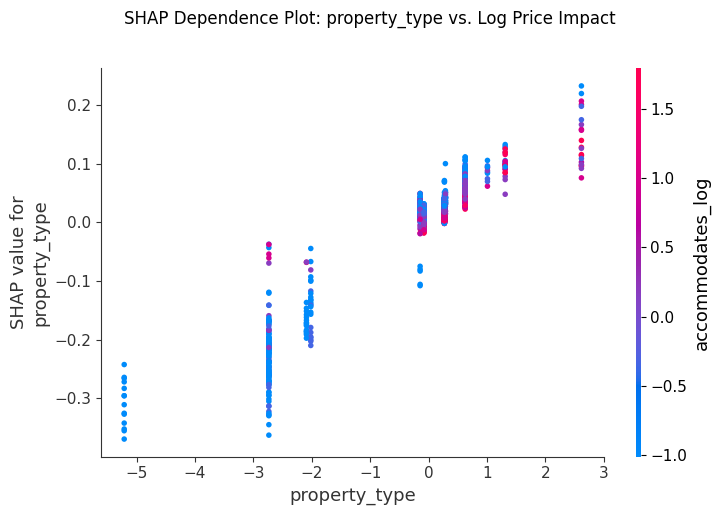


Plotting dependence for: room_type_Entire_home/apt


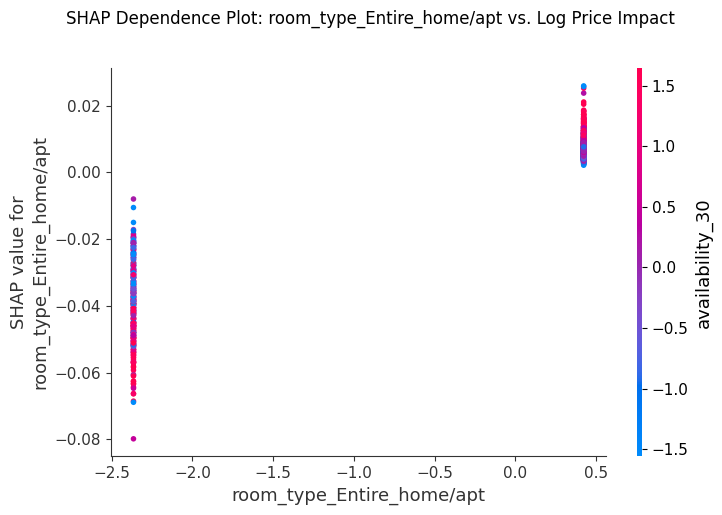


Plotting dependence for: neighbourhood_group_Old_Town_Center


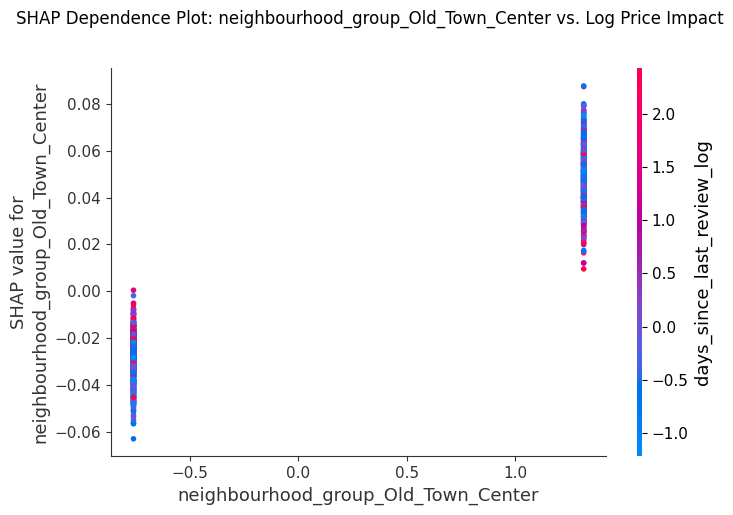


Plotting dependence for: amenity_tv


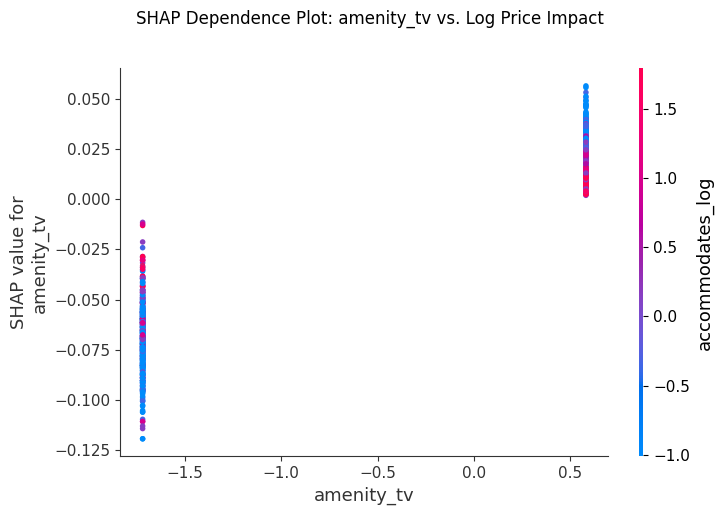


Plotting dependence for: host_response_time_Unknown


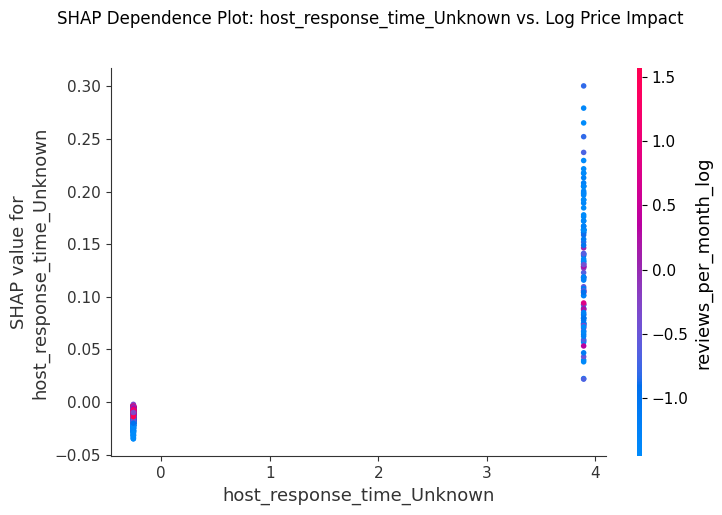

In [11]:
# I3.4 SHAP Dependence Plots
if 'shap_values' in locals() and shap_values is not None and 'X_test_scaled' in locals() and X_test_scaled is not None and 'importance_df_builtin' in locals(): # Or use perm importance df
    
    # Select top N features based on SHAP bar plot (or previous importance DataFrames)
    # Use importance_df_builtin for now, assuming it holds the sorted list from I2.1 or SHAP bar plot logic
    # Re-calculate SHAP mean abs if needed: shap_abs_mean = np.abs(shap_values).mean(axis=0)
    
    # Using previously calculated built-in importance for ranking example:
    if 'importance_df_builtin' in locals():
         top_features = importance_df_builtin['Feature'].head(8).tolist() # Get top 8 feature names
         print(f"\nGenerating SHAP Dependence Plots for Top Features: {top_features}")
    else:
         print("Warning: Importance DataFrame not found, cannot determine top features automatically.")
         top_features = [] # Define manually if needed

    # Ensure feature names are valid columns in X_test_scaled
    valid_top_features = [f for f in top_features if f in X_test_scaled.columns]
    
    if valid_top_features:
        for feature_name in valid_top_features:
            try:
                print(f"\nPlotting dependence for: {feature_name}")
                # Create dependence plot, automatically finding interactions
                shap.dependence_plot(
                    feature_name,
                    shap_values,
                    X_test_scaled,
                    interaction_index="auto", # Automatically finds strongest interaction
                    show=False
                )
                # Customize title if needed
                plt.suptitle(f'SHAP Dependence Plot: {feature_name} vs. Log Price Impact', y=1.02)
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"   Error plotting dependence for {feature_name}: {e}")
    else:
        print("No valid top features identified for dependence plots.")

else:
    print("Error: SHAP values, test data, or importance rankings not available.")

*Observations from SHAP Dependence Plots (Size Metrics):*

1.  **`bedrooms_log` vs. Log Price Impact (Interaction: `property_type`):**
    *   **Trend:** There is a strong, generally positive relationship. As the log number of bedrooms increases, its SHAP value (impact on predicted log price) increases significantly. The jump is particularly noticeable going from 0 bedrooms (log value approx -inf, but likely represented near the left axis after scaling/imputation if any) to 1 bedroom (log value 0.69), and further increases for 2+ bedrooms (log values > 1).
    *   **Interaction (`property_type` - Target Encoded):** The color indicates the target-encoded value of `property_type`. Pink/red points (higher average price property types) tend to have *higher* SHAP values for a *given* number of bedrooms compared to blue points (lower average price property types). This means the positive impact of having more bedrooms is **amplified for property types that are already typically more expensive**. For example, adding a bedroom to an 'Entire rental unit' likely increases the predicted price more than adding a bedroom to a 'Private room' context (although `room_type` encoding captures the main effect, `property_type` adds nuance).

2.  **`accommodates_log` vs. Log Price Impact (Interaction: `calculated_host_listings_count_private_rooms_log`):**
    *   **Trend:** A clear positive, roughly linear trend is visible. Increasing the log number of accommodated guests consistently increases the predicted log price.
    *   **Interaction (`calculated_host_listings_count_private_rooms_log`):** The coloring by the log count of the host's private rooms doesn't show an extremely strong or obvious interaction pattern here. There might be a very slight tendency for listings accommodating many people (right side) to have slightly lower SHAP values if the host manages many private rooms (blue dots perhaps slightly lower than pink dots on the far right), but the effect seems weak compared to the main trend of `accommodates_log`. The primary driver is simply the accommodation capacity itself.

3.  **`bathrooms_log` vs. Log Price Impact (Interaction: `bedrooms_log`):**
    *   **Trend:** A positive relationship exists, particularly noticeable when going from 0.5/1 bathroom (log values around 0-0.7) to 1.5 or 2+ bathrooms (log values > 1). Having more bathrooms increases the predicted log price. There seems to be diminishing returns at very high bathroom counts (log values > 3).
    *   **Interaction (`bedrooms_log`):** The coloring shows a clear interaction. For a given number of bathrooms (e.g., log value around 1.5-2), listings with *more* bedrooms (pink/red points) tend to get a *larger positive boost* from the bathrooms compared to listings with fewer bedrooms (blue points). This makes sense – the value of having multiple bathrooms is greater in a larger, multi-bedroom house than in a small studio.

## 4. Summarize Interpretation Findings

This section consolidates the insights gained from analyzing feature importances (Built-in, Permutation) and SHAP values (Summary Plots, Dependence Plots) for the final XGBoost model.

### Summary of Key Findings

1.  **Most Important Features:** There is strong agreement across methods (Permutation Importance, SHAP Mean Absolute Value, XGBoost Built-in Gain) that the primary drivers of predicted `log_price` are:
    *   **Listing Size:** `bedrooms_log` and `accommodates_log` consistently rank at the very top. Higher values strongly increase predicted price. `bathrooms_log` is also highly important, with a positive impact.
    *   **Review Characteristics:** Review recency (`days_since_last_review_log`), review velocity (`reviews_per_month_log`), and overall rating (`review_scores_rating`) are significant predictors. More recent reviews, higher review frequency, and better ratings generally lead to higher predicted prices.
    *   **Availability:** Short-term availability (`availability_30`) has a notable impact, with lower availability (fewer days bookable) correlating with higher predicted prices, likely reflecting demand. Long-term availability (`availability_365`) also contributes.
    *   **Location:** Geographic coordinates (`longitude`, `latitude`) rank as important, indicating the model captures fine-grained location effects beyond just the broader neighbourhood group. Specific high-value neighbourhood groups (e.g., `neighbourhood_group_Old_Town_Center`) also contribute positively when isolated via OHE.
    *   **Property Type (Target Encoded):** The target-encoded `property_type` feature is highly important, confirming that the inherent average price level associated with different property types (like 'Entire rental unit' vs. 'Private room in condo') is a key factor.

2.  **Feature Impact Direction & Shape (from SHAP):**
    *   **Positive Impact:** Increased `bedrooms_log`, `accommodates_log`, `bathrooms_log`, `reviews_per_month_log`, `review_scores_rating`, `num_amenities`, `host_duration_days` generally increase the predicted `log_price`. Being in `neighbourhood_group_Old_Town_Center` or having `room_type_Entire_home/apt` also increases it. Lower `availability_30` increases price.
    *   **Negative Impact:** Higher `days_since_last_review_log` (older or no reviews) decreases the predicted `log_price`. Being a `room_type_Shared_room` likely decreases it. Unknown host response time also appears to have a negative impact relative to known, quick response times.
    *   **Non-Linearities:** While many size/count relationships show roughly monotonic increases on the log scale, the SHAP dependence plots hint at some non-linearities (e.g., potentially diminishing returns for very high bathroom counts, complex patterns for `longitude`/`latitude`).

3.  **Key Interaction Effects (from SHAP):**
    *   **Bedrooms & Property Type:** The positive impact of additional bedrooms (`bedrooms_log`) is amplified for property types that tend to be more expensive (higher target-encoded `property_type` value).
    *   **Bathrooms & Bedrooms:** The positive impact of additional bathrooms (`bathrooms_log`) is greater for listings with more bedrooms (`bedrooms_log`), indicating bathrooms are more valuable in larger properties.
    *   *(Include other strong interactions observed in the dependence plots, e.g., potentially involving location, accommodates, or specific amenities).*

4.  **Other Observations & Surprises:**
    *   **Encoding Effectiveness:** Target Encoding for `property_type` proved highly effective (high importance). OHE captured value for key `room_type` and `neighbourhood_group` categories. Frequency Encoding (used in the first iteration) appeared ineffective based on later importance rankings.
    *   **Feature Redundancy:** Keeping both original and log-transformed versions of features initially showed split importance; removing originals clarified the rankings.
    *   **Low Importance Features:** `num_host_verifications`, some specific amenity flags (besides `amenity_tv`), and some host flags (`host_is_superhost`, `host_identity_verified`) showed relatively low importance *in this specific model*, suggesting they might be less critical than core size, location, review, and availability metrics *or* their effects are captured indirectly by other features.

**Overall Interpretation:** The model primarily relies on listing size, location (both coordinates and broader group), property type, availability, and key review metrics (rating, recency, velocity) to predict prices. The relationships are generally intuitive (e.g., bigger/better located/higher rated listings are more expensive), but the model also captures significant interaction effects (like size and property type interacting). While performance improved significantly after data prep revisions, the remaining unexplained variance (R² ≈ 0.62) suggests further opportunities exist, likely through incorporating more dynamic (calendar) or nuanced features.